In [ ]:
!pip install nvcc4jupyter
%load_ext nvcc4jupyter

The nvcc4jupyter extension is already loaded. To reload it, use:
  %reload_ext nvcc4jupyter


In [ ]:
!nvidia-smi
!nvcc --version

Tue Apr 15 03:59:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

#Terminologies

1. **Kernel**: A small program that runs on the GPU. Think of it as a job you give to all the workers, like “add two numbers.”
2. **Threads**: The individual workers. Each thread does the same job but on different pieces of data. For example, one thread adds 1+2, another adds 3+4.
3. **Thread Blocks**: Threads are grouped into teams called blocks. Each block is like a small crew that works closely together. A block can have up to 1024 threads (like 1024 workers in one crew).
4. **Grid**: All the blocks together form a grid. It’s like all the crews working on the same big project. A grid can have thousands of blocks.

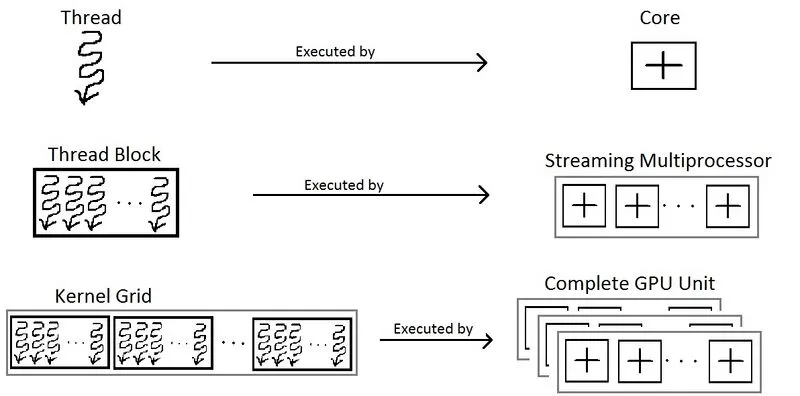

5. **Warps**: Threads in a block are split into groups of 32 threads called warps. It’s like a mini-team that moves together, doing the same step at the same time.
6. **Streams**: A way to line up jobs so some can run at the same time, like scheduling tasks to keep the GPU busy.
7. **Host vs. Device**:
    - Host: The CPU that gives orders and sends data.
    - Device: The GPU that does the fast calculations.
8. **Memory Limits**:
    - Threads per Block: Max 1024 threads.
    - Blocks per Grid: Millions possible, but depends on the GPU.
    - Shared Memory per Block: Up to 48KB.
    - Registers per Thread: Up to 255, but only about 64KB total per block (shared among threads).
    - If you use too much memory or too many threads, the GPU might not be able to run the job.
9. **Memory (Storage)**: Threads need places to store numbers while working.
    - **Global Memory**: A big storeage room all threads can use, but it's slow. GPU have gigabytes of global memory.
    - **Shared Memory**: A small, fast storage area **for one block to share**. Each block gets up to **48KB**.
    - **Registers**: Tiny, super fast storage for each thread. Each thread gets up to **255 registers**.
    - **Constant Memory**: A special read-only storage for data all thread use. Limited to **64KB** total.
    - **Textual Memory**: A storage type food for pictures or 3D data. Like a map threads can look at.
10. **How It Works**: The CPU sends the kernel (job) and data to the GPU. The GPU splits the work across thousands of threads in blocks, and they all calculate at once.

In [6]:
%%writefile check_resource_limit.cu

#include<stdio.h>

// This code snippet is used to check the maximum threads can be in one block for this particular GPU
int main(){
    int device;
    cudaDeviceProp props;
    cudaGetDevice(&device);
    cudaGetDeviceProperties(&props, device);
    printf("Maximum threads per block: %d\n", props.maxThreadsPerBlock);
}

Overwriting check_resource_limit.cu


In [7]:
!nvcc check_resource_limit.cu -o resource_check -arch=compute_75 -code=sm_75 --generate-code arch=compute_75,code=sm_75

In [8]:
!./resource_check

Maximum threads per block: 1024


In [ ]:
%%writefile vector_add.cu

#include <stdio.h>

// Host: the CPU
// Device: The GPU
// Kernel: a function that runs on the GPU and is called from the CPU


// __global__ is use to define a kernel.
__global__ void AddTwoVectors(float A[], float B[], float C[]) {
    int i = threadIdx.x;    // Each thread is given a unique threadID
    C[i] = A[i] + B[i];
}

int main(){
    int N = 1000;
    float A[N], B[N], C[N];

    // Initialize vectors A and B
    for (int i = 0; i < N; i++) {
        A[i] = 1;
        B[i] = sinf(i * 0.1f);
    }


    float *d_A, *d_B, *d_C;     // Device pointers for vectors A, B, and C

    /*
    Note that in CUDA programming, you can't directly use host arrays (like A, B, and C) with kernel launches (<<<number_of_blocks, number_of_threads_per_block>>>).

    CUDA kernel operate on device memory, so you need to pass device pointers (d_A, d_B, and d_C) to the kernel for it to operate on.

    Beyond that, we need to allocate memory on the device by using cudaMalloc, and copy data between host and device using cudaMemcpy.
    */

    // Allocate memory on the device for vectors A, B, and C
    cudaMalloc((void **)&d_A, N * sizeof(float));
    cudaMalloc((void **)&d_B, N * sizeof(float));
    cudaMalloc((void **)&d_C, N * sizeof(float));


    // Copy vectors A and B from host to device
    cudaMemcpy(d_A, A, N * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, B, N * sizeof(float), cudaMemcpyHostToDevice);


    // The number of CUDA threads that execute the above kernel can be spefified using <<< >>> notation.
    // Kernel invocation with N threads
    AddTwoVectors<<<1, N>>>(d_A, d_B, d_C);


    /*

    cudaDeviceSynchronize() is used to synchronize the device and the host thread.

    When this function is called, the host thread will wait until all previously issued CUDA commands on the device are completed before continuing execution.
    */


    // Check for errors in kernel launch (e.g. invalid configuration)
    cudaError_t error = cudaGetLastError();


    if(error != cudaSuccess) {
        printf("CUDA error: %s\n", cudaGetErrorString(error));
        exit(-1);
    }


    // Wait until all CUDA threads are executed
    cudaDeviceSynchronize();


    // copy vector C from device to host
    cudaMemcpy(C, d_C, N * sizeof(float), cudaMemcpyDeviceToHost);


    // Print the first 10 elements of C for verification
    printf("First 10 elements of C:\n");
    for (int i = 0; i < 10; i++) {
        printf("C[%d] = %f\n", i, C[i]);
    }

    // Save the entire C array to a file for plotting
    FILE *fp = fopen("vector_c.txt", "w");
    if (fp == NULL) {
        printf("Error opening file!\n");
        exit(-1);
    }
    for (int i = 0; i < N; i++) {
        fprintf(fp, "%f\n", C[i]);
    }
    fclose(fp);


    // Free device memory
    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_C);
}


Overwriting vector_add.cu


In [ ]:
!nvcc vector_add.cu -o vector_add -arch=compute_75 -code=sm_75 --generate-code arch=compute_75,code=sm_75

In [ ]:
!./vector_add

First 10 elements of C:
C[0] = 1.000000
C[1] = 1.099833
C[2] = 1.198669
C[3] = 1.295520
C[4] = 1.389418
C[5] = 1.479426
C[6] = 1.564642
C[7] = 1.644218
C[8] = 1.717356
C[9] = 1.783327


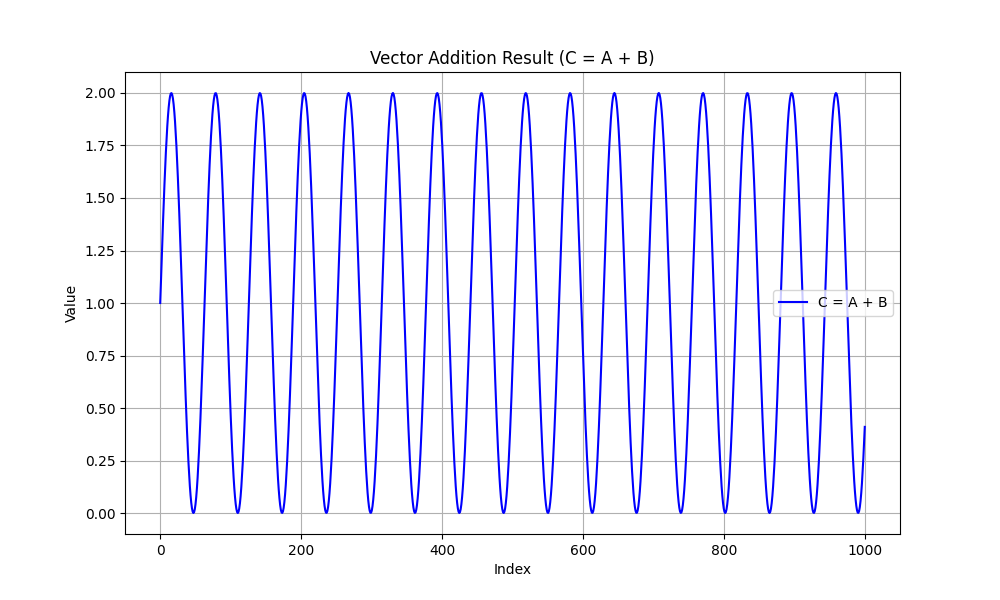

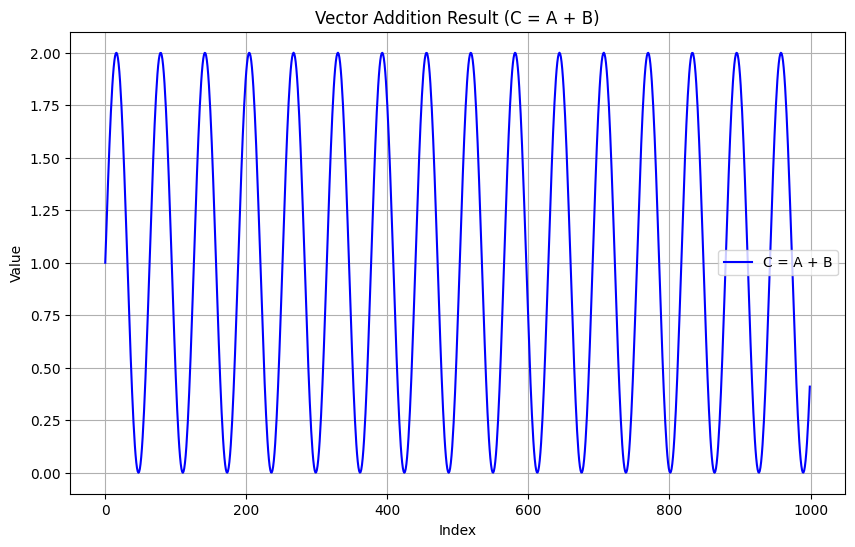

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Load the data from the file
with open("vector_c.txt", "r") as f:
    C = [float(line.strip()) for line in f]

# Create an index array for the x-axis (0 to 999)
x = np.arange(len(C))

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(x, C, label='C = A + B', color='blue')
plt.title('Vector Addition Result (C = A + B)')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend()

# Save the plot to a file (since plt.show() isn't used in Colab as per guidelines)
plt.savefig('vector_add_plot.png')

# Display the plot in Colab (optional, for user to see immediately)
from IPython.display import Image
Image('vector_add_plot.png')